In [526]:
from rootpy.io import root_open
import pandas
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [527]:
%env OMP_NUM_THREADS=4

env: OMP_NUM_THREADS=4


In [528]:
print 5

5


In [529]:
import root_numpy

In [530]:
data = root_numpy.root2array("../../data_ROOT/Pi0s_j29_tuple.root", treename='dumpEcal/BPi0Areas')
data_ecal = root_numpy.root2array("../../data_ROOT/Pi0s_j29_tuple.root", treename='dumpEcal/PSDigis')

Класс, который соответсвует области калориметра, проверяяет, не выскакивает ли квадрат за калориметр

In [531]:
for ind in range(0,2):
    print ind

0
1


In [558]:
class Bound(object):
    def __init__(self, left=0, right=0, bottom=0, top=0, multiplier = 1, divider = 1):
        self.left = left
        self.right = right
        self.top = top
        self.bottom = bottom
        self.multiplier = multiplier
        self.divider = divider

class Area(object):
    def __init__(self):
        self.inner = Bound()
        self.outer = Bound()
    def get_inner_bound():
        return self.inner
    def get_outer_bound():
        return self.outer
    
    def get_function_selector(self, ind):
        return {1:self.get_inner_bound, 2:self.get_outer_bound}[ind]
        
    def OverOut(self, x1, x2):
        return ((x1 >=self.outer.right - 1 or x1<=self.outer.left + 1) or (x2 >= self.outer.top - 1 or x2<=self.outer.bottom + 1))
    def OverIn(self, x1, x2):
        #print self.inner.left, self.inner.right, self.inner.bottom,  self.inner.top
        #print x1, x2
        #print (x1 >=self.inner.left - 1 and x1<=self.inner.right + 1)
        #print (x2 >= self.inner.bottom - 1 and x2<=self.inner.top + 1)
        return ((x1 >=self.inner.left - 1 and x1<=self.inner.right + 1) and (x2 >= self.inner.bottom - 1 and x2<=self.inner.top + 1))
    def InCalorimeter(self, x1, x2):        
        return not(self.OverOut(x1,x2)) and not(self.OverIn(x1,x2))
        
    def reconstr_param(self, x1, x2, is_outer):
        answ = []
        axes = {'x':x1, 'y':x2}
        if (is_outer == 1):
            coordinates = {'left':(x1-1, x2), 'bottom':(x1, x2-1), 'top':(x1, x2+1), 'right':(x1+1, x2)}
            big_dict = {'y':{"top":self.outer.top, "bottom":self.outer.bottom}, 'x':{"left":self.outer.left, "right":self.outer.right}}
        else:
            coordinates = {'left':(x1+1, x2), 'bottom':(x1, x2+1), 'top':(x1, x2-1), 'right':(x1-1, x2)}
            big_dict = {'y':{"top":self.inner.top, "bottom":self.inner.bottom}, 'x':{"left":self.inner.left, "right":self.inner.right}}
        for elem in big_dict:
            for side in big_dict[elem]: #elem - x или y # короче это например space.outer.top - elem[7] - 0 или 1, отстутп   
                dist = abs(big_dict[elem][side] - axes[elem])
                if (dist <= 1):
                    answ = [(coordinates[side][0], coordinates[side][1], (2-ind), side) for ind in range(2-dist)] #dist 0 или 1
                    return answ
        return []

class Inner(Area):
    def __init__(self):
        self.inner = Bound(25,38,23,40,1,1)
        self.outer = Bound(14,49,8,55,2,3) #из 2-го в 1ый
        self.multiplier_in = 1
        self.divider_in = 1
        self.multiplier_out = 2
        self.divider_out = 3
    
    def NotInCalorimeter(self, x1, x2):  #x1- elem6, x2-elem7
        return self.OverIn(x1, x2)
        #return ((x1 >=self.inner.left + 1 and x1<=self.inner.right - 1) and (x2 >= self.inner.bottom + 1 and x2<=self.inner.top - 1)) #for Inner region "True" if in center hole
        
    
class Middle(Area):
    def __init__(self):
        self.inner = Bound(19,44,15,48,3,2)#из 1-го в 2-ый
        self.outer = Bound(12,51,0,63,1,2)# из 1 в 0-ый
    def NotInCalorimeter(self, x1, x2):  #x1- elem6, x2-elem7 for Inner region "True" if in center hole 
        return False #every square could be restore
    
class Outer(Area):
    def __init__(self):
        self.inner = Bound(21,42,15,48,2,1)
        self.outer = Bound(0,63,6,57,1,1)
    def NotInCalorimeter(self, x1, x2):  #x1- elem6, x2-elem7 for Inner region "True" if in center hole 
        return self.OverOut(x1, x2)     

In [559]:
abs(-3)

3

In [560]:
areas = {2:Inner(), 1:Middle(), 0:Outer()}
space = areas[1]
print space.outer.bottom
print space.outer.bottom + 1 >= 15 >= space.outer.bottom - 1 
print (space.inner.left<=22<=space.inner.right)

0
False
True


In [577]:
def get_energy(cell_x_new, cell_y_new, ecal_data_groups, ps_data_groups):
    #energy_ = 0.0
    answ = []
    for group in [ecal_data_groups, ps_data_groups]:
        try:
            energy_data = group.get_group((cell_y_new,cell_x_new))
            energy_ = energy_data['energy'].values[0]
        except:
            energy_ = 0.0
        answ.append(energy_)
    return answ
    


def make_vector_left(cell_x, cell_y, area_bound, n_area_bound, ecal_data_groups, ps_data_groups, multiplier, divider):
    vect_ = []
    vect_ps = []
    for y in [cell_y -2, cell_y -1, cell_y, cell_y +1, cell_y +2]:
        cell_x_new = n_area_bound.left
        cell_y_new = multiplier*(y - area_bound.bottom)/divider +n_area_bound.bottom
        vect_.append(get_energy(cell_x_new, cell_y_new, ecal_data_groups, ps_data_groups)[0])
        vect_ps.append(get_energy(cell_x_new, cell_y_new, ecal_data_groups, ps_data_groups)[1])
    return vect_,vect_ps
        
def make_vector_right(cell_x, cell_y, area_bound, n_area_bound, ecal_data_groups, ps_data_groups, multiplier, divider):
    vect_ = []
    vect_ps = []
    for y in [cell_y -2, cell_y -1, cell_y, cell_y +1, cell_y +2]:
        cell_x_new = n_area_bound.right
        cell_y_new = multiplier*(y - area_bound.bottom)/divider +n_area_bound.bottom
        vect_.append(get_energy(cell_x_new, cell_y_new, ecal_data_groups, ps_data_groups)[0])
        vect_ps.append(get_energy(cell_x_new, cell_y_new, ecal_data_groups, ps_data_groups)[1])
    return vect_,vect_ps
        
def make_vector_top(cell_x, cell_y, area_bound, n_area_bound, ecal_data_groups, ps_data_groups, multiplier, divider):
    vect_ = []
    vect_ps = []
    for x in [cell_x -2, cell_x -1, cell_x, cell_x +1, cell_x +2]:
        cell_x_new = multiplier*(x - area_bound.left)/divider + n_area_bound.left
        cell_y_new = n_area_bound.top
        vect_.append(get_energy(cell_x_new, cell_y_new, ecal_data_groups, ps_data_groups)[0])
        vect_ps.append(get_energy(cell_x_new, cell_y_new, ecal_data_groups, ps_data_groups)[1])
    return vect_,vect_ps

def make_vector_bottom(cell_x, cell_y, area_bound, n_area_bound, ecal_data_groups, ps_data_groups, multiplier, divider):
    vect_ = []
    vect_ps = []
    for x in [cell_x -2, cell_x -1, cell_x, cell_x +1, cell_x +2]:
        cell_x_new = multiplier*(x - area_bound.left)/divider + n_area_bound.left
        cell_y_new = n_area_bound.bottom
        vect_.append(get_energy(cell_x_new, cell_y_new, ecal_data_groups, ps_data_groups)[0])
        vect_ps.append(get_energy(cell_x_new, cell_y_new, ecal_data_groups, ps_data_groups)[1])
    return vect_,vect_ps

def assigment_left(ecal_square, ps_square, vect_, vect_ps, distance_, type_='norm'): #type - out - norm, in - inv
    distanses = {"norm":2-distance_, "inv":2+distance_}
    ecal_square[distanses[type_], :] = vect_ #если координата по x меняем y столбец
    ps_square[distanses[type_], :] = vect_ps
    
def assigment_right(ecal_square, ps_square, vect_, vect_ps, distance_,  type_='norm'):
    distanses = {"norm":2+distance_, "inv":2-distance_}
    ecal_square[distanses[type_], :] = vect_
    ps_square[distanses[type_], :] = vect_ps
    
def assigment_top(ecal_square, ps_square, vect_, vect_ps, distance_,  type_='norm'):
    distanses = {"norm":2+distance_, "inv":2-distance_}
    ecal_square[:, distanses[type_]] = np.array(vect_)#если координата по y меняем x столбец
    ps_square[:, distanses[type_]] = np.array(vect_ps)
    
def assigment_bottom(ecal_square, ps_square, vect_, vect_ps, distance_,  type_='norm'):
    distanses = {"norm":2-distance_, "inv":2+distance_}
    ecal_square[:, distanses[type_]] = np.array(vect_)#если координата по y меняем x столбец
    ps_square[:, distanses[type_]] = np.array(vect_ps)

In [584]:
#axis - left, right, top or bottom
#n_area_bound - boundary layer from neighbour area (inner or outer, depends on)
# n_ecal_data, n_ps_data - matrix of neighbour area (counted outside)

make_vector = {'left':make_vector_left, \
               'right':make_vector_right,\
               'top':make_vector_top,\
               'bottom':make_vector_bottom}

assigment = {'left':assigment_left,\
             'right':assigment_right,\
             'top':assigment_top,\
              'bottom':assigment_bottom}


def reconstruct_new(cell_x, cell_y, distance_, axis, area_bound, n_area_bound, ecal_square, ps_square, n_ecal_data, n_ps_data, type_='norm'):
    ecal_data_groups = n_ecal_data.groupby(("col","row")) # y - колонка, x - ряд
    ps_data_groups = n_ps_data.groupby(("col","row"))
    if (type_ == 'norm'):
        multiplier,divider = area_bound.multiplier, area_bound.divider
    else:
        multiplier,divider = area_bound.multiplier, area_bound.divider
    #print "multiplier, divider", multiplier,divider
    vect_,vect_ps = make_vector[axis](cell_x, cell_y, area_bound, n_area_bound, ecal_data_groups, ps_data_groups,multiplier,divider)
    assigment[axis](ecal_square, ps_square, vect_, vect_ps, distance_, type_)
    #print "square after", ecal_square
    return ecal_square, ps_square

In [585]:
19 43

SyntaxError: invalid syntax (<ipython-input-585-fa0a4742c89f>, line 1)

In [586]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

x_6 = []
x_7 = []
sq_old = []
sq_new = []

areas = {2:Inner(), 1:Middle(), 0:Outer()}

def make_sample_new(samples, area, is_photon, need_hypo):   #samples - list of root-sample , 
                                                        #is_photon - '1' if photon, '0' if pi0, hypo - hypothesis, 
                                                        #need_hypo - is hypothethis take into account
    square_X_5_All = []
    square_y = []
    energy_list = []
    features_list = []
    hypo_list = []
    k = 0
    u = 0
    for string_ in samples:
        i = 0
        print string_
        f = root_open(string_)
        if (is_photon):
            data = root_numpy.root2array(string_, 
                                 treename='dumpEcal/PhotonAreas')
        else:
            data = root_numpy.root2array(string_, 
                                 treename='dumpEcal/BPi0Areas')   
        space = areas[area]
        print space.inner.top
        dataframe = pandas.DataFrame(root_numpy.root2array(string_, treename='dumpEcal/EcalDigis'))
        groups = dataframe.groupby(("eventID","area"))
        dataframe_ps = pandas.DataFrame(root_numpy.root2array(string_, treename='dumpEcal/PSDigis'))
        groups_ps = dataframe_ps.groupby(("eventID","area"))
        print len(data)
        for indd, elem in enumerate(data):
            a = np.array(elem[8]).reshape((1,5,5))
            b = np.array(elem[9]).reshape((1,5,5))
            id_ = elem[0]
            photon = 100
            if (need_hypo):
                photon = elem[10]

            if (space.NotInCalorimeter(elem[6],elem[7])):
                continue
            try:
                dataframe1 = groups.get_group((id_,area))
            except:
                continue
            if (len(dataframe1) == 0 or elem[5] != area):
                continue
                
            if(space.OverIn(elem[6], elem[7])): #in
                #print "in", i
                n_space = areas[area+1]
                try:
                    dataframen = groups.get_group((id_,area+1))
                    dataframe1_psn = groups_ps.get_group((id_,area+1))
                except:
                    continue
                answ = space.reconstr_param(elem[6], elem[7], 0)
                for param in answ:
                    a,b = reconstruct_new(param[0], param[1], param[2], param[3] ,space.inner, n_space.outer, a.reshape((5,5)), b.reshape((5,5)), dataframen,  dataframe1_psn, 'inv')

            elif(space.OverOut(elem[6], elem[7])): #out
                #print "out", elem[6], elem[7]
                n_space = areas[area-1]
                try:
                    dataframen = groups.get_group((id_,area-1))
                    dataframe1_psn = groups_ps.get_group((id_,area-1))
                except:
                    continue
                answ = space.reconstr_param(elem[6], elem[7], 1)
                for param in answ:
                    a,b = reconstruct_new(param[0], param[1], param[2], param[3] ,space.outer, n_space.inner, a.reshape((5,5)), b.reshape((5,5)), dataframen,  dataframe1_psn)
            if (elem[1] > 2000 and photon > -99):
                i += 1
                if (i%5000 == 0):
                    print i
                hypo_list.append(photon)
                square_X_5_All.append(np.concatenate((a.reshape((1,5,5)), b.reshape((1,5,5))), 0))
                square_y.append(is_photon)
                energy_list.append(elem[1])

    return square_X_5_All, hypo_list, square_y, energy_list

In [587]:
square_X_5_All2, hypo_list, square_y, energy_list = make_sample_new(["../../data_ROOT/Pi0s_j29_tuple.root"],1,0,1)

../../data_ROOT/Pi0s_j29_tuple.root
48
7719


In [588]:
square_X_5_All1, hypo_list, square_y, energy_list = make_sample(["../../data_ROOT/Pi0s_j29_tuple.root"],1,0,1)

../../data_ROOT/Pi0s_j29_tuple.root
7719
5000


In [ ]:
plt.figure(figsize = [6,22])
i = 0
for index, sq in enumerate(sq_new[:10]):
    i = i + 1
    plt.subplot(10, 2, i)
    plt.imshow(square_X_5_All1[ind][0].reshape(5,5), interpolation = 'nearest')
    i = i + 1
    plt.subplot(10, 2, i)
    plt.imshow(sq.reshape(5,5), interpolation='nearest')
plt.savefig("reconstruct2.png")
plt.show()

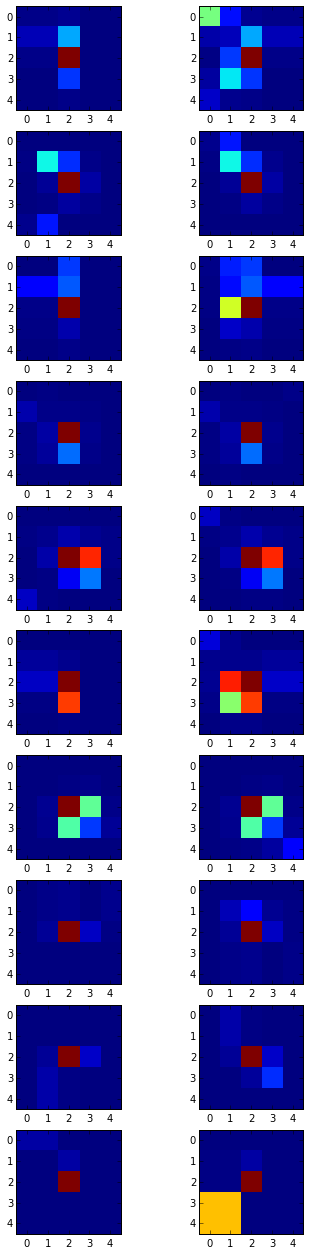

10


In [598]:
err = 0
plt.figure(figsize = [6,22])
i = 0
for ind in range(len(square_X_5_All1)):
    if (np.sum(square_X_5_All1[ind][0]) != np.sum(square_X_5_All2[ind][0]) and err < 10):
        i = i + 1
        plt.subplot(10, 2, i)
        plt.imshow(square_X_5_All1[ind][0].reshape(5,5), interpolation = 'nearest')
        i = i + 1
        plt.subplot(10, 2, i)
        plt.imshow(square_X_5_All2[ind][0].reshape(5,5), interpolation = 'nearest')
        err += 1
plt.show()
print err

In [294]:
for elem in square_X_5_All1[0][0]:
    print elem

[ 207.41055298  134.11982727  172.44960022  -13.15735435    0.        ]
[  322.50387573  1108.49621582  1595.53344727   235.9365387     30.05623245]
[   461.06976318  38430.03125     79297.9453125    1497.80175781
    182.62214661]
[  719.40966797  2519.5065918   4262.96972656   998.78253174   119.13096619]
[  66.34363556  240.8085022   260.65936279  220.67149353  -38.426754  ]


In [301]:
for elem in square_X_5_All2[1][0]:
    print elem
print np.sum(square_X_5_All2[1][0])

[   0.            0.          349.59243774    0.            0.        ]
[    0.             0.          6389.01904297     0.             0.        ]
[     0.            0.        21859.671875      0.            0.      ]
[    0.             0.          3842.71459961     0.             0.        ]
[   0.            0.          196.34591675    0.            0.        ]
32637.3


In [299]:
for elem in square_X_5_All1[1][0]:
    print elem
print np.sum(square_X_5_All1[1][0])

[ 207.41055298  134.11982727  172.44960022  -13.15735435    0.        ]
[  322.50387573  1108.49621582  1595.53344727   235.9365387     30.05623245]
[   461.06976318  38430.03125     79297.9453125    1497.80175781
    182.62214661]
[  719.40966797  2519.5065918   4262.96972656   998.78253174   119.13096619]
[  66.34363556  240.8085022   260.65936279  220.67149353  -38.426754  ]
133033.0


In [310]:
len(square_X_5_All2)

1

In [19]:
import cPickle as pickle
with open("../../obt_data/RecArea1rec_only.pcl",'w') as fout:
    pickle.dump([square_X_5_All, hypo_list, square_y, energy_list],fout)

In [ ]:
square_X_5_All_ph, hypo_list_ph, square_y_ph, energy_list_ph = make_sample(["../../data_ROOT/Photons_j30_tuple.root","../../data_ROOT/Photons_j36_tuple.root"],1,1,1)

In [13]:
import cPickle as pickle
with open("../../obt_data/RecArea1rec_only_ph.pcl",'w') as fout:
    pickle.dump([square_X_5_All_ph, hypo_list_ph, square_y_ph, energy_list_ph],fout)

In [20]:
import cPickle as pickle
with open("../../obt_data/RecArea1Ph.pcl",'w') as fout:
    pickle.dump([square_X_5_All_ph, hypo_list_ph, square_y_ph, energy_list_ph],fout)

In [ ]:
class Top(object):
    def transform1(self,x):
        return x+1
    def transform2(self,x):
        return x*2

In [15]:
calculate(10, Top())

(11, 20)

In [16]:
calculate(10, Left())

(9, 30)

In [17]:
s2f={'top':Top(), 'left':Left()}

In [18]:
calculate(20, s2f['left'])

(19, 60)

In [19]:
calculate(20, s2f['top'])

(21, 40)